In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
#import re
#from util import load_metric
from scipy.stats import spearmanr, pearsonr, zscore, rankdata, ttest_ind, ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

## Functions

In [3]:
def read_csv(path):
    return pd.read_csv(path, sep=";", index_col=0)

In [4]:
# def find_transitions(df, var):
#     cols = [col for col in df.columns if col.startswith(var)]
#     cols.sort()
#     transitions = [tuple(col.split("_")[-1].split(":")) for col in cols]
#     return transitions

In [5]:
# Identifying a shared vocabulary
def shared_voc(df1, df2, only_core = True):
    shared_words = set(df1.index).intersection(set(df2.index))
    if only_core:
        shared_words = [w for w in shared_words if w.startswith(("A1_", "N1_", "N2_", "V1_"))]
    shared_words.sort()
    return shared_words
    

In [6]:
# Identifying a shared variables
def shared_variables(df1, df2, var):
    vec1 = set([col for col in df1.columns if col.startswith(var)])
    vec2 = set([col for col in df2.columns if col.startswith(var)])
    shared_vec = list(vec1.intersection(vec2))
    shared_vec.sort()
    return shared_vec  

In [7]:
def count_only(df, df_ref, min_freq):
    df = df.copy()
    #transitions = find_transitions(df, var)
    transitions = [tuple(col.split("_")[-1].split(":")) for col in df.columns]
    var = df.columns[0].split("_")[0]
    for word in df.index:
        for ti, tj in transitions:
            f_at_ti = df_ref.loc[word][f"frq_{ti}"]
            f_at_tj = df_ref.loc[word][f"frq_{tj}"]
            if f_at_ti < min_freq:
                df.at[word, f"{var}_{ti}:{tj}"] = np.nan
            if f_at_tj < min_freq:
                df.at[word, f"{var}_{ti}:{tj}"] = np.nan
    return df

In [8]:
# Find parallel vectors
def parallel_vec(
    df1, # dataframe 1 (e.g. Flashback)
    df2, # dataframe 2 (e.g. Familjeliv)
    var, # variable (e.g. rectified change) 
    only_core = True, # only core dog whistle expressions, "the main eleven"
    use_external_freq = False, # Base minimum frequency on an external (third) dataframe
    ext_freq_df1 = None, # Base minimum frequency on an external (third) dataframe
    ext_freq_df2 = None, # Base minimum frequency on an external (third) dataframe
    min_freq = 5, 
    force_exclude = None,
    verbose = True
):
    
    vocabulary = shared_voc(df1, df2, only_core)
    variables  = shared_variables(df1, df2, var)
    
    # Select a sub-dataframe
    selected_df1 = df1.loc[vocabulary][variables]
    selected_df2 = df2.loc[vocabulary][variables]
    
#     print(selected_df1)
#     print(selected_df2)
    
    if min_freq != None:
        if use_external_freq:
            selected_df1 = count_only(selected_df1, ext_freq_df1, min_freq)
            selected_df2 = count_only(selected_df2, ext_freq_df2, min_freq)            
            
        else:    
            selected_df1 = count_only(selected_df1, df1, min_freq)
            selected_df2 = count_only(selected_df2, df2, min_freq)
    
#     print(selected_df1)
#     print(selected_df2)    
    
    vec1 = []
    vec2 = []
    ref  = []
    for word in vocabulary:
        vec1.extend(selected_df1.loc[word][variables].tolist())
        vec2.extend(selected_df2.loc[word][variables].tolist())
        ref.extend([f"{word}_{var}" for var in variables])
    assert len(vec1) == len(vec2)
    
    if verbose:
        print(f"N step 0: {len(vocabulary)*len(variables)} (length voc x length var)")
        print(f"N step 1: {selected_df1.count().sum()}, {selected_df2.count().sum()} (min frequency only)")
    
    XY = []
    for x, y, w in zip(vec1, vec2, ref):
        if pd.isna(x): 
            continue
        if pd.isna(y):
            continue
        #print(w)
        if force_exclude != None:
            if w == force_exclude:
                continue
        XY.append((x, y, w))
    
    
    vec1, vec2, ref = zip(*XY)
    
#     if norm != None:
#         vec1 = norm(vec1)
#         vec2 = norm(vec2)

    if verbose:
        print(f"N step 2: {len(vec1)}, {len(vec2)} (no NaN in pairs)")    
    
    return list(vec1), list(vec2), list(ref) 
    

In [9]:
def binary(vec, th):
    new_v = []
    for v in vec:
        new_v.append(int(v>th))
    return new_v

In [10]:
def cohen_d(x,y): # https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [11]:
def find_breaks(array):
    breaks = []
    for i, lbl in enumerate(array[1:], start=1):
        this_label = lbl.split("_")[1]      # N1_globalist_...
        prev_label = array[i-1].split("_")[1]
        #print(this_label, prev_label)
        if this_label != prev_label: 
            #print(i)
            breaks.append(i)
    return breaks

In [12]:
def clean_ref_vector(ref):
    return [" ".join(r.replace("_rch", "").replace("_gch", "").split("_")[1:]) for r in ref]

In [13]:
def vis(v1, v2, ref, name_v1_as_fb=True, clean_ref = True):
    #N = range(len(v1))
    if name_v1_as_fb:
        label1 = "Flashback"
        label2 = "Familjeliv"
    else:
        label1 = "V1"
        label2 = "v2"
    
    if clean_ref:
        plt.plot(clean_ref_vector(ref), v1, "-b", label=label1)
        plt.plot(clean_ref_vector(ref), v2, "-r", label=label2)
    else: 
        plt.plot(ref, v1, "-b", label=label1)
        plt.plot(ref, v2, "-r", label=label2)        
    for line in find_breaks(ref):
        plt.axvline(line, color="black", linestyle="dashed")
    plt.xticks(rotation=90, ha='left')
    
    #Note
    #plt.yticks(np.arange(0.5, len(my_df_num.index), 1), my_df_num.index)
    #plt.xticks(np.arange(0.5, len(my_df_num.columns), 1), my_df_num.columns)
    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)    
    
    plt.legend(loc="upper left")
    fig = plt.gcf()
    fig.set_size_inches(20, 8)
    #plt.legend(loc="upper left")
    fig.align_xlabels()
    
    plt.rc('font', size=10)          # controls default text sizes
    #plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    #plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    plt.rc('legend', fontsize=16)    # legend fontsize
    #plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    
    
    
    plt.show()

In [14]:
standard_tests = [ # var, min_freq, 
    ("rch", 5),
    ("rch", 10),
    ("gch", 5),
    ("gch", 10)
]

In [15]:
def compare(
    df1, 
    df2, 
    tests=standard_tests, 
    use_exfrq = False, 
    ex_freq1 = None, 
    ex_freq2 = None,
    force_exclude = None
):
    results = []
    distrib = []
    
    for measure, criterion in tests:
        d = dict()
        
        name = f"{measure}_{criterion}"
        
        d["Test-version"] = name
        
        v1, v2, ref = parallel_vec(
            df1, 
            df2, 
            measure, 
            use_external_freq = use_exfrq,
            ext_freq_df1 = ex_freq1,
            ext_freq_df2 = ex_freq2,
            min_freq = criterion,
            force_exclude = force_exclude,
            verbose = True,
        )
        
        print("Length:", len(v1), len(v2))
        
        distrib.append((name, v1, v2, ref))
        
        spearman = spearmanr(v1, v2)
        pearson  = pearsonr(v1, v2)
        ks       = ks_2samp(v1, v2)
        mw       = mannwhitneyu(v1, v2)
        ttest    = ttest_ind(v1, v2)
        
        d["Spearman's rho"]       = spearman.statistic
        d["p (spearman)"]         = spearman.pvalue
        d["Pearson's r"]          = pearson.statistic
        d["p (pearson)"]          = pearson.pvalue
        d["Kolmogorov–Smirnov D"] = ks.statistic
        d["p (KS-test)"]          = ks.pvalue
        d["Mann–Whitney U"]       = mw.statistic
        d["p (MW-test)"]          = mw.pvalue
        d["p(v1 > v2) (MW-test)"] = mw.statistic / (len(v1) * len(v2)) 
        # https://journals.sagepub.com/doi/pdf/10.1177/1536867X1201200202 
        # https://www.researchgate.net/post/How-can-I-calculate-the-effect-sizes-of-small-samples-20-for-non-parametric-tests-Wilcoxon-and-Mann-Whitney-U
        d["Student's t"]          = ttest.statistic
        d["p (t-test)"]           = ttest.pvalue
        d["Cohen's d"]            = cohen_d(v1, v2)
        
        results.append(d)
    
    results = pd.DataFrame(results)
    #results = results.set_index(['Test-version'])
    
    return results, distrib
    

In [16]:
def ecdf(v1, v2):
   
    x1 = np.sort(v1)
    y1 = np.arange(len(x1))/float(len(x1))
    plt.plot(x1, y1)
    
    x2 = np.sort(v2)
    y2 = np.arange(len(x2))/float(len(x2))
    plt.plot(x2, y2)
    
    plt.xlabel("Δ-value")
    plt.ylabel("Cumulative Probability")
    
    plt.show()


## DATA

In [17]:
results_dir = Path("../../dw_results")

In [18]:
files = sorted(os.listdir(results_dir))
_ = [print(file) for file in files]

bert-v0
change_tables
fb_pol-time_bin-radical3-full.csv
fb_pol-time_bin-radical3-restricted.csv
fb_pol-yearly-bert-fb_nli.csv
fb_pol-yearly-bert-sentence-bert-swedish-cased.csv
fb_pol-yearly-bert-sts_fbmodel.csv
fb_pol-yearly-bert-sts_fbmodel_big_40epochs.csv
fb_pol-yearly-cluster-sentence-bert-swedish-cased.csv
fb_pol-yearly-radical3-full.csv
fb_pol-yearly-radical3-restricted.csv
fm_smh-yearly-bert-sentence-bert-swedish-cased.csv
fm_smh-yearly-cluster-sentence-bert-swedish-cased.csv
fm_smh-yearly-radical3-full.csv
fm_smh-yearly-radical3-restricted.csv
messy-05-09-2023
neighbors


In [19]:
#df_yearly         = read_csv(results_dir / "fb_pol-yearly-radical3-full.csv")
df_yearly_dwt     = read_csv(results_dir / "fb_pol-yearly-radical3-restricted.csv")
df_bert_kb        = read_csv(results_dir / "fb_pol-yearly-bert-sentence-bert-swedish-cased.csv")
#df_yearly_ref     = read_csv(results_dir / "fm_smh-yearly-radical3-full.csv")
df_yearly_dwt_ref = read_csv(results_dir / "fm_smh-yearly-radical3-restricted.csv")
df_bert_kb_ref    = read_csv(results_dir / "fm_smh-yearly-bert-sentence-bert-swedish-cased.csv")
df_cluster        = read_csv(results_dir / "fb_pol-yearly-cluster-sentence-bert-swedish-cased.csv")
df_cluster_ref    = read_csv(results_dir / "fm_smh-yearly-cluster-sentence-bert-swedish-cased.csv")

### Narrow ...

In [ ]:
narrow_tests = [ # var, min_freq, 
    ("rch", 11),
    ("gch", 11)
]

## SGNS

In [ ]:
res, dist = compare(
    df_yearly_dwt, 
    df_yearly_dwt_ref, 
    tests=[ # var, min_freq, 
        ("rch", 10),
        ("gch", 10),
        ],
#     use_exfrq = True,
#     ex_freq1 = df_bert_kb, 
#     ex_freq2 = df_bert_kb_ref    
)

In [ ]:
res, dist = compare(
    df_yearly_dwt, 
    df_yearly_dwt_ref, 
    tests=[ # var, min_freq, 
        ("rch", 10),
        ("gch", 10),
        ],
    use_exfrq = True,
    ex_freq1 = df_bert_kb, 
    ex_freq2 = df_bert_kb_ref    
)

In [ ]:
#dist

In [ ]:
res.T

In [ ]:
for name, A, B, ref in dist:
    print(name.upper())
    vis(A, B, ref)
    ecdf(A, B)
    plt.scatter(zscore(A), zscore(B))
    plt.show()

## BERT

In [20]:
res, dist = compare(
    df_bert_kb, 
    df_bert_kb_ref, 
    tests=[ # var, min_freq, 
    #("rch", 10),
    ("gch", 10)
    ],
    #force_exclude = "N1_återvandring_rch_2006:2007"
    force_exclude = "N1_återvandring_gch_2006:2007"
#     use_exfrq = True,
#     ex_freq1 = df_bert_kb, 
#     ex_freq2 = df_bert_kb_ref      
)

N step 0: 209 (length voc x length var)
N step 1: 157, 47 (min frequency only)
N step 2: 44, 44 (no NaN in pairs)
Length: 44 44


In [21]:
res.T

,0
Test-version,gch_10
Spearman's rho,-0.088513
p (spearman),0.567762
Pearson's r,-0.118028
p (pearson),0.445438
Kolmogorov–Smirnov D,0.75
p (KS-test),2.43869e-12
Mann–Whitney U,107
p (MW-test),6.9129e-13
p(v1 > v2) (MW-test),0.0552686


GCH_10


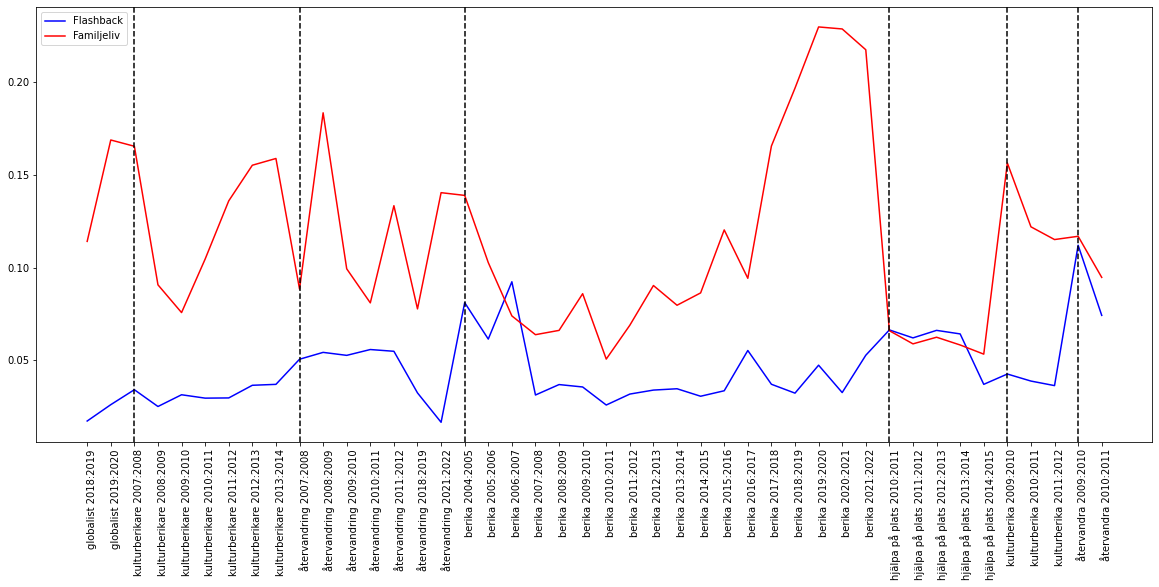

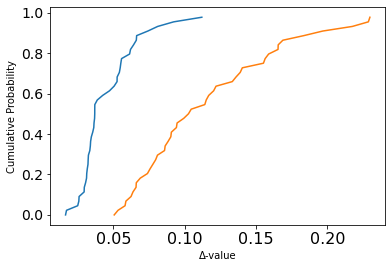

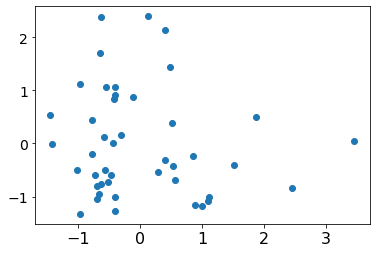

In [22]:
for name, A, B, ref in dist:
    print(name.upper())
    vis(A, B, ref)
    ecdf(A, B)
    plt.scatter(zscore(A), zscore(B))
    plt.show()

In [30]:
for a, b, r in zip(A, B, ref):
    print(f"{r:<35}{b-a:>8.4f}")

N1_globalist_gch_2018:2019           0.0969
N1_globalist_gch_2019:2020           0.1427
N1_kulturberikare_gch_2007:2008      0.1313
N1_kulturberikare_gch_2008:2009      0.0656
N1_kulturberikare_gch_2009:2010      0.0443
N1_kulturberikare_gch_2010:2011      0.0750
N1_kulturberikare_gch_2011:2012      0.1063
N1_kulturberikare_gch_2012:2013      0.1187
N1_kulturberikare_gch_2013:2014      0.1218
N1_återvandring_gch_2007:2008        0.0379
N1_återvandring_gch_2008:2009        0.1292
N1_återvandring_gch_2009:2010        0.0467
N1_återvandring_gch_2010:2011        0.0252
N1_återvandring_gch_2011:2012        0.0785
N1_återvandring_gch_2018:2019        0.0453
N1_återvandring_gch_2021:2022        0.1238
V1_berika_gch_2004:2005              0.0578
V1_berika_gch_2005:2006              0.0412
V1_berika_gch_2006:2007             -0.0184
V1_berika_gch_2007:2008              0.0325
V1_berika_gch_2008:2009              0.0292
V1_berika_gch_2009:2010              0.0503
V1_berika_gch_2010:2011         

## Clusters

In [ ]:
set([col.split("_")[0] for col in df_cluster.columns if col.startswith(("km", "ac"))])

In [ ]:
cluster_tests = [ # var, min_freq, 
    ("kms_", 5),
    ("kms_", 10),
    ("kmsr50", 5),
    ("kmsr50", 10),
    ("km15", 30)
]

In [ ]:
#df_cluster
#df_cluster_ref
res, dist = compare(
    df_cluster, 
    df_cluster_ref, 
    tests=[("kms_", 10)]
)

In [ ]:
res.T

In [ ]:
for name, A, B, ref in dist:
    print(name.upper())
    vis(A, B, ref)
    plt.scatter(zscore(A), zscore(B))
    plt.show()